In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Reporting Checklist

## Data Load stage
* Load in data files               ✅
* Get range of time series         ✅
* Add and run data 'fix' functions ✅ 5th April

## Outputs
* Template
    - Title page with report range and data types
    - Date
* Weekly aggregates
    - Temperature between 9am-5pm, temperature overnight (11pm-6am?)
    - Average humidity at these times as well
    - % of time Light > 0
* Daily graphs (try to fit one page per day) 

## Implementation
* Python module for processing BAX data with functions for
    - Reading in the data from a file (or set of files)
    - Calculating stats and aggregates over the data
    - Producing graphs for given time ranges


In [2]:
from datahandling import *
from graphing import *
import numpy as np

In [3]:
df = readfile("./testdata/fetch.bax")

In [4]:
df.dtypes.index

Index(['Name', 'RSSI', 'Type', 'SequenceNo', 'TransmitPower', 'Battery',
       'Humidity', 'Temp', 'Light', 'PIRCount', 'PIREnergy', 'Switch'],
      dtype='object')

In [5]:
t_start, t_end = (df.index.min(), df.index.max())
print(str(t_start) +' to '+ str(t_end))

2016-03-27 23:59:53 to 2016-04-03 23:59:39


In [6]:
dfs = split_by_id(df)
names = unique_sensors(df)
print(names)

dfs = fix_humidity(dfs)
dfs = diff_pir(dfs)
dfs = fix_temp(dfs)
dfs[names[0]][:4]

/usr/local/lib/python3.5/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.5/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


['80418A51' '80524F69' '80B207A1' '80F82619']


,Name,RSSI,Type,SequenceNo,TransmitPower,Battery,Humidity,Temp,Light,PIRCount,PIREnergy,Switch,Event,PIRDiff
DateTime,,,,,,,,,,,,,,
2016-03-27 23:59:53,80418A51,-72,1,131,20,2671,39.53,12.6,0,0,53,1,NaN,NaN
2016-03-28 00:00:23,80418A51,-72,1,132,20,2671,39.45,12.6,0,0,442,1,NaN,NaN
2016-03-28 00:00:52,80418A51,-72,1,133,20,2671,39.41,12.5,0,0,848,1,NaN,1.033333
2016-03-28 00:01:21,80418A51,-72,1,134,20,2671,39.45,12.5,0,0,1254,1,NaN,0.000000


In [7]:
d=dfs['80418A51']
(d.loc[:,['Event']][d['Event'] == True].astype(float) *10)[:4]

,Event
DateTime,
2016-03-28 12:51:08,10
2016-03-29 07:31:02,10
2016-03-29 07:37:24,10
2016-03-29 11:22:38,10


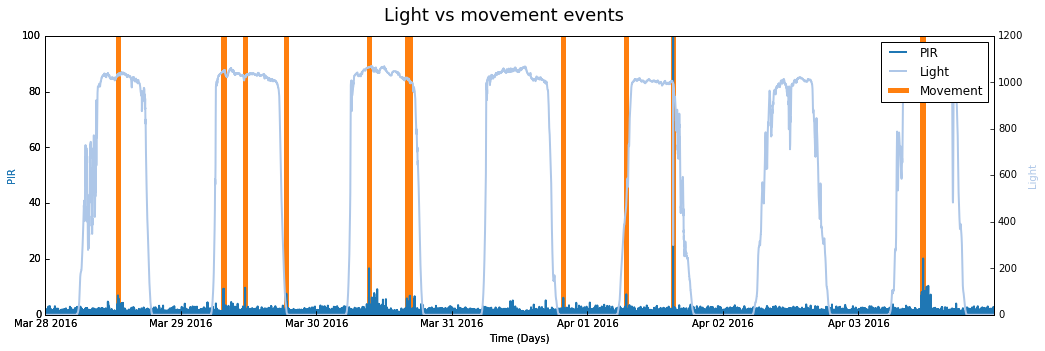

In [8]:
# When graphing the same sensor, only need to provide one index as it's the same length as the others
graph(x_data=d.loc[t_start:t_end,].index,
      y_data=d.loc[t_start:t_end,['PIRDiff', 'Light', 'Event']].transpose().values,
      x_label="Time (Days)", 
      title="Light vs movement events",
      y_series=["PIR", "Light", "Movement"], 
      plot_func=['plot', 'plot', 'vlines'], 
      ylim=[(0,100),None],
      twin_x=True, 
      legend=True)

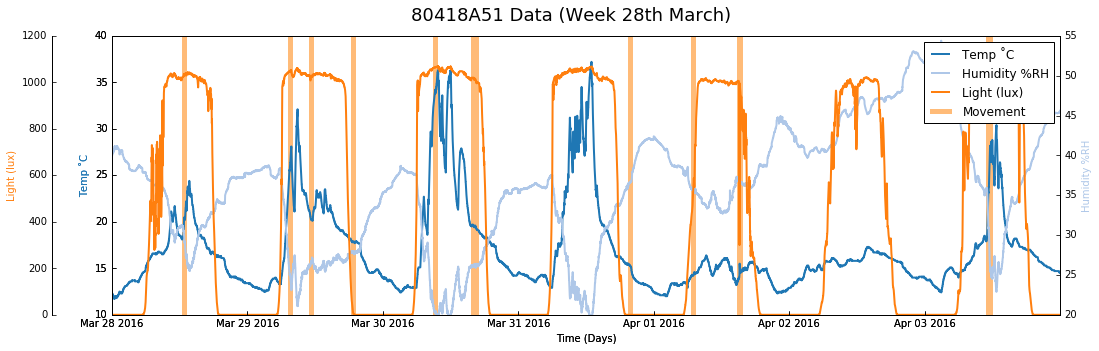

In [9]:
graph(x_data=d.loc[t_start:t_end,].index,
      y_data=d.loc[t_start:t_end,['Temp', 'Humidity', 'Light', 'Event']].transpose().values,
      x_label="Time (Days)", 
      y_series=["Temp ˚C", "Humidity %RH", "Light (lux)", "Movement"], 
      title='80418A51 Data (Week 28th March)', 
      plot_func=["plot", "plot", "plot", "vlines"],
      twin_x=True, 
      legend=True)

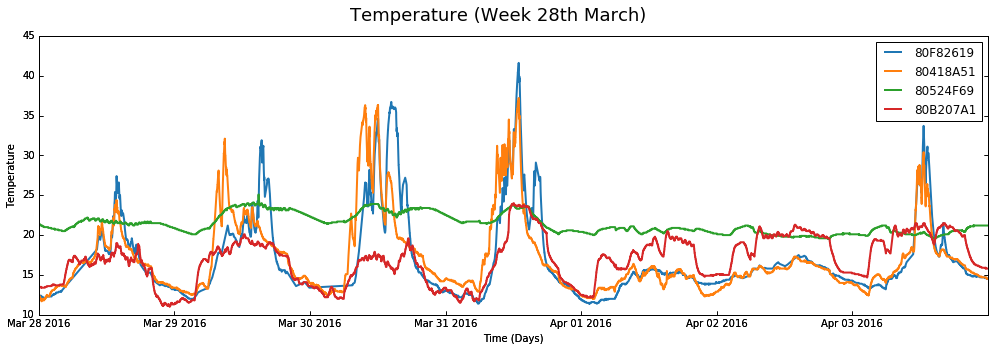

In [10]:
# When graphing multiple sensors, each needs its own index
graph([ dfs[i].loc[t_start:t_end, 'Temp'].index  for i in dfs ], 
      [ dfs[i].loc[t_start:t_end, 'Temp'].values for i in dfs ],
      x_label="Time (Days)",
      y_label="Temperature",
      y_series=list(dfs.keys()),
      title='Temperature (Week 28th March)',
      colors=graph.colors[::2],
      twin_y=True,
      legend=True)

In [11]:
print(t_start, t_end)
days=pd.date_range(t_start, t_end, freq='D', normalize=True)

2016-03-27 23:59:53 2016-04-03 23:59:39


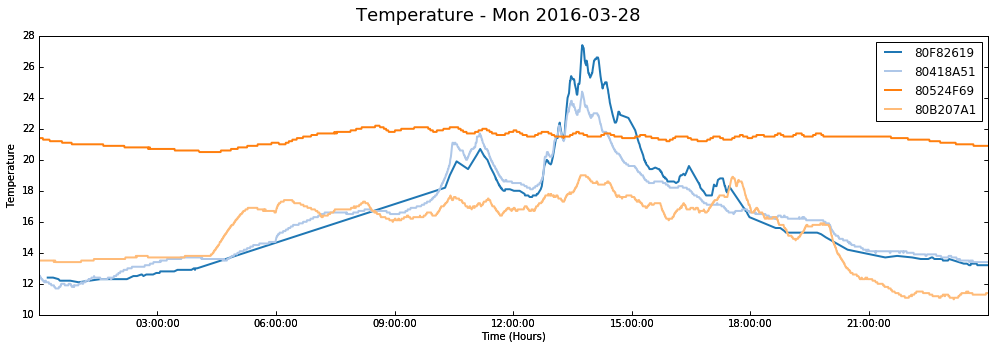

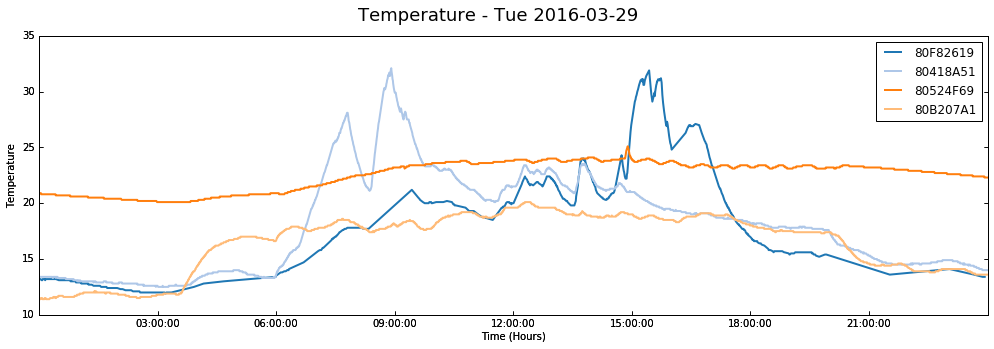

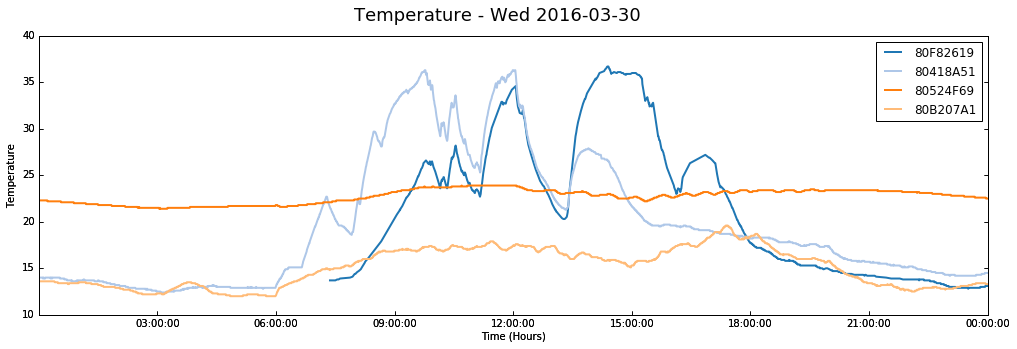

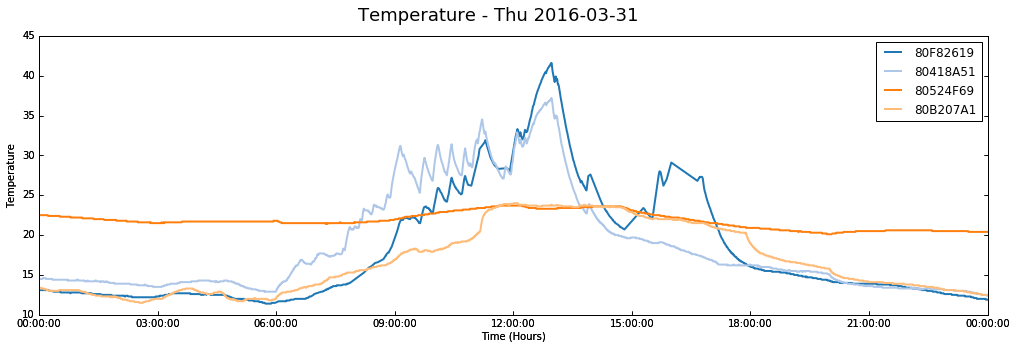

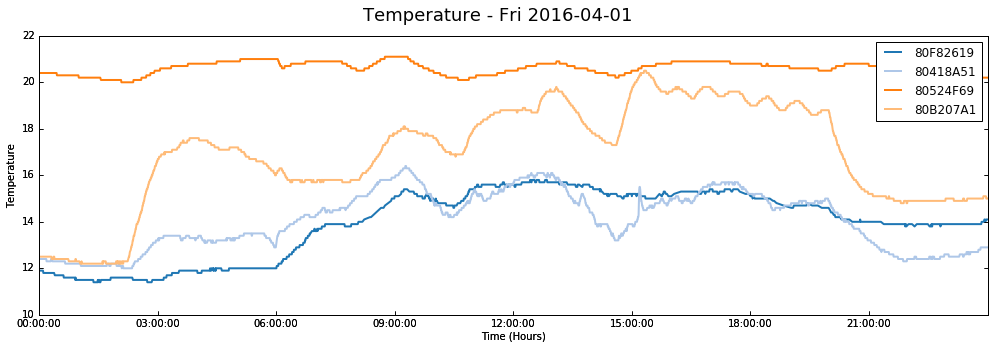

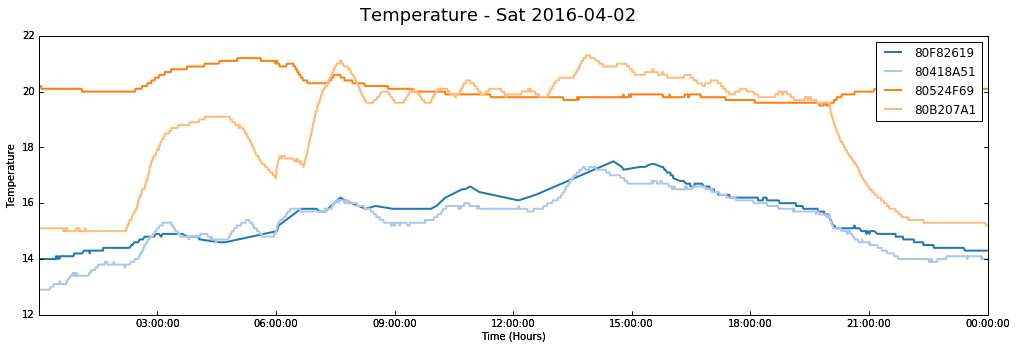

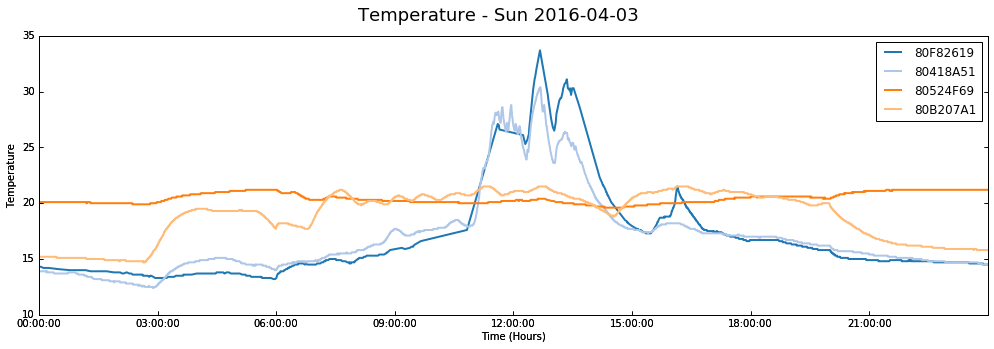

In [12]:
import calendar

for day in days:
    start = day
    end = day + pd.Timedelta('1 day')
    
    x_data = [ dfs[i].loc[start:end,].index  for i in dfs ]
    #print(start, end, sum( [len(x) for x in x_data] ))
    
    # Ignore days with one value (e.g. fetch interface returns 23:59:58 from the previous day)
    if sum( [len(x) for x in x_data] ) <= len( x_data ):
        continue                         
    
    graph([ dfs[i].loc[start:end,].index  for i in dfs ], 
          [ dfs[i].loc[start:end, 'Temp'].values for i in dfs ],
          x_label="Time (Hours)",
          y_label="Temperature",
          y_series=list(dfs.keys()),
          title="Temperature - {0} {1}".format(calendar.day_abbr[start.dayofweek], start.date()),
          #colors=graph.colors[::2],
          twin_y=True,
          legend=True,
          savefig=True,
          savedir='figures')

In [13]:
!ls figures

Temperature - Fri 2016-04-01.png Temperature - Sat 2016-04-02.png Temperature - Thu 2016-03-31.png Temperature - Wed 2016-03-30.png
Temperature - Mon 2016-03-28.png Temperature - Sun 2016-04-03.png Temperature - Tue 2016-03-29.png
